# **MODELAGEM E SIMULAÇÃO DO LEVITADOR ELETROMAGNÉTICO (MAGLEV)**

## **BIBLIOTECAS UTILIZADAS**

In [1]:
import numpy as np
import sympy as sp
from IPython.display import display, Math, Latex, Markdown

## **SISTEMA**

### **Equação de movimento (Entrada: corrente, Saída: posição):**

\begin{align}
  \ddot{x} = g - \dfrac{F(x,I)}{m}
\end{align}

onde $F(x,I)$ é a força magnética exercida pela bobina sobre o imã/cilindro. 

Nosso melhor modelo para $F$ hoje é:
\begin{align}
  F(x,I)=\dfrac{k\,I^2}{(x+\mu)^2}
\end{align}

### **Amplificador**
Se a entrada for tensão, substituir:
\begin{align}
  I = Gv
\end{align}
onde $G$ é o ganho do amplificador

### **Sensor**
Se a posição for a saída do sensor (em Volts), então usar $y = f(x)$, onde $f$ é a função do sensor.

Temos uma função $f$ (bem complicada) para modelar o sensor óptico. Ver artigo [Modelagem MAGLEV](https://drive.google.com/file/d/1dnAVKEA_xjPZEv8Yq5wTmNkQC51b8FsX/view?usp=sharing).

### **Espaço de estados**
O modelo de espaço de estados não-linear, considerando $x_1$ a posição e $x_2$ a velocidade, fica:

\begin{align}
  \dot{x}_1 &= x_2\\
  \dot{x}_2 &= g - \dfrac{kI^2}{m(x_1-\mu)^2}
\end{align}

### **Equilíbrio**

O sistema está em equilíbrio quando todas as derivadas em relação ao tempo são nulas. Assim:
\begin{align}
  0 &= x_2^*\\
  mg &= \dfrac{kI_0^2}{(x_1^*+\mu)^2}
\end{align}

Desta forma, dada  uma posição de equilíbrio $x_1^*=x_0$ podemos achar a corrente de equilíbrio $I_0$ ou vice-versa. 

### **Linearização**

Seja:
\begin{align}
  \Delta x_1 &= x_1 - x_1^*\\
  \Delta x_2 &= x_2 - x_2^*\\
  \Delta I &= I - I_0
\end{align}

Calculando o Jacobiano no ponto de equilíbrio e organizando a notação, temos:
\begin{align}
  \Delta \dot{x}_1 &= \Delta x_2\\
  \Delta \dot{x}_2 &= -a\,\Delta I +\lambda^2 \Delta x_1\\
  y &= x_1
\end{align}

onde:
\begin{align}
a &= \dfrac{1}{m}\,\left.\dfrac{\partial F}{\partial I}\right|_{x_0,I_0}= \frac{2kI_0}{m(x_0+\mu)^2}\\
  -\lambda^2 &= \frac{1}{m}\,\left.\dfrac{\partial F}{\partial x}\right|_{x_0,I_0}= \dfrac{-2kI_0^2}{(x_0+\mu)^3} \Rightarrow \lambda = \displaystyle\sqrt{\dfrac{2kI_0^2}{m(x_0+\mu)^3}}
\end{align}



## **CONTROLE**

### **Definindo o sistema de controle**

Estados do controlador $\mathbf{z}$, onde:
- $z_1$ é a estimativa de $\Delta x_1$
- $z_2$ é a estimativa de $\Delta x_2$
- $e$ é o estado do integrador 

Sinal de controle é calculado como:
\begin{align}
  \Delta I = -\mathbf{Kz} - K_i e
\end{align}
onde $\mathbf{K}$ e $K_i$ são calculados da alocação de pólos com o sistema aumentado:
\begin{align}
  \mathbf{A}_a &= \left[\begin{array}{cc} \mathbf{A} & \mathbf{0}\\ -\mathbf{C} & 0\end{array}\right]\\
  \mathbf{B}_a &= \left[\begin{array}{c} \mathbf{B} \\ \mathbf{0}\end{array}\right]
\end{align}

O controlador final possui duas entradas: a variação da saída do sistema (para o controlador poder trabalhar linearizado) e o sinal de referência.
\begin{align}
  \mathbf{u} &= \left[\begin{array}{c} \Delta x_1 \\ r\end{array}\right]
\end{align}

Colocando o observador, então, o compensador completo pode ser implantado usando as seguintes equações de estado
\begin{align}
  \dot{\mathbf{z}} = \mathbf{A_rz+B_ru}
\end{align}
onde as matrizes do controlador são:
\begin{align}
  \mathbf{A_r} &= \left[\begin{array}{cc} \mathbf{A-BK-LC} & -\mathbf{B}K_i\\ \mathbf{0} & 0\end{array}\right]\\
  \mathbf{B_r} &= \left[\begin{array}{cc} \mathbf{L} & \mathbf{0}\\ {-1} & 1\end{array}\right]
\end{align}


### **Construindo o sistema com o Sympy**

In [2]:
#Lambda
ld = sp.symbols('\lambda')

#a
a = sp.symbols('a')

A = sp.Matrix([[0, 1],[ld**2, 0]])
B = sp.Matrix([[0],[-a]])
C = sp.Matrix([[1,0]])
n = A.shape[0]
display(Math('\mathbf{A} = ' + sp.latex(A)))
print('')
display(Math('\mathbf{B} = ' + sp.latex(B)))
print('')
display(Math('\mathbf{C} = ' + sp.latex(C)))
print('')
display(Math('\Delta \dot{\mathbf{x}} = ' +  sp.latex(A) + '\Delta\mathbf{x} + ' + sp.latex(B) + '\Delta I'))
print('')
display(Math('y = ' + sp.latex(C) + '\Delta\mathbf{x}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### **Regulado integral: matrizes aumentadas**

In [3]:
Aa = sp.Matrix(sp.BlockMatrix([[A, sp.zeros(2,1)],[-C,sp.zeros(1,1)]]))
Ba = sp.Matrix(sp.BlockMatrix([[B], [sp.zeros(1,1)]]))

display(Math('\mathbf{A}_a = ' + sp.latex(Aa)))
print('')
display(Math('\mathbf{B}_a = ' + sp.latex(Ba)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### **Projeto do regulador**

In [4]:
# Laplace
s = sp.symbols('s')

# Ganho aumentado
K = sp.MatrixSymbol('K',1,3)


Amf = sp.Matrix(Aa-Ba@K)
alpha = Amf.charpoly(s)

display(Math('\\alpha(s) = ' + sp.latex(alpha.expr)))

#@title Ganhos do regulador integral

# Polo desejado
p = sp.symbols('p')
# Laplace
s = sp.symbols('s')
# Poli desejado
alpha_des = sp.collect(sp.expand((s+p)**3),s)

# Sistema de equações, por comparação de polinômios
sistema = [sp.Equality(alpha.coeffs()[3-i], alpha_des.coeff(s,i)) for i in range(3)]

# Resolve o sistema
sol = sp.solve(sistema,sp.Matrix(K))
K = sp.Matrix(K).subs(sol)

# Apresenta as soluções
print('')
display(Math('K_1 = '+ sp.latex(K[0,0])))
print('')
display(Math('K_2 = '+ sp.latex(K[0,1])))
print('')
display(Math('K_3 = '+ sp.latex(K[0,2])))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### **Projeto do observador**

Supondo os pólos do observador em $s=-q$, $q > p$.

In [5]:
# Ganhos do observador
L = sp.MatrixSymbol('L',2,1)

# Poli característico do observador
alphao = sp.Matrix((A-L@C)).charpoly(s)

# Poli desejado do observador
q = sp.symbols('q')
alphao_des = sp.collect(sp.expand((s+q)**2),2)

# Sistema de equações, por comparação de polinômios
sistema2 = [sp.Equality(alphao.coeffs()[2-i], alphao_des.coeff(s,i)) for i in range(2)]

# Resolve o sistema
sol2 = sp.solve(sistema2,sp.Matrix(L))
L = sp.Matrix(L).subs(sol2)

# Apresenta as soluções
display(Math('L_1 = '+ sp.latex(L[0,0])))
print('')
display(Math('L_2 = '+ sp.latex(L[1,0])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### **Equações de estado do controlador**

In [6]:
Ki = K[0,2]
Kr = K[0,0:2]

Ar = sp.Matrix(sp.BlockMatrix([[A-B@Kr-L@C, -B*Ki]]))
Ar = sp.Matrix(sp.BlockMatrix([[Ar],[sp.Matrix(sp.zeros(1,3))]]))
Br = sp.Matrix(sp.BlockMatrix([ [L, sp.zeros(2,1)]  ] ))
Br = sp.Matrix(sp.BlockMatrix([[Br],[sp.Matrix([[-1,1]])]]))

U = r'\left[ \begin{array}{c} \Delta x_1 \\ r \end{array}\right]' 
display(Math('\mathbf{\dot{z}} = ' + sp.latex(Ar) + '\mathbf{z} + ' + sp.latex(Br) + U))

<IPython.core.display.Math object>

## **SIMULAÇÃO EM MALHA FECHADA**


### **Equações de estados**

In [7]:
# Derivadas dos estados do maglev
dx1, dx2 = sp.symbols(['\dot{x}_1', '\dot{x}_2'])
# Estados do maglev
x1, x2 = sp.symbols(['x_1', 'x_2'])
# Constatnes do maglev
g,k,m,mu = sp.symbols(['g','k','m','\mu'])
# Estados do controlador
z1, z2, z3 = sp.symbols(['z_1','z_2','z_3'])
# Derivadas dos estados do controlador
dz1, dz2, dz3 = sp.symbols(['\dot{z}_1','\dot{z}_2','\dot{z}_3'])
# Corrente e corrente de equilíbrio
I0,I = sp.symbols(['I_0','I'])
# Posição de equilíbrio
x0 = sp.symbols('x_0')
# Sinais de entrada do controlador
y,r = sp.symbols(['\Delta\ x_1','r'])

# Matriz de ganhos do controlador
k1,k2,k3 = sp.symbols(['K_1','K_2','K_3'])
kk = sp.Matrix([k1,k2,k3]).T

# Vetor de estados (vai fazer conta com ele) 
z = sp.Matrix([z1,z2,z3])

# Lista das derivadas dos estados do controlador (apenas para escrever)
dz = [dz1,dz2,dz3]

# Matriz dos sinais de entrada
U = sp.Matrix([y,r])

# Lista de equações
e = []
e.append(sp.Eq(dx1, x2))
e.append(sp.Eq(I, I0 - (kk@z)[0]))
e.append(sp.Eq(dx2, g - k*I**2/(m*(x1+mu)**2)))
e.append(sp.Eq(y, x1-x0))

# Equações do controlador
f = (Ar@z + Br@U)
for i in range(f.shape[0]):
  e.append(sp.Eq(dz[i],f[i]))

# Resultado
for i in range(len(e)):
  print('')
  display(Math(sp.latex(e[i])))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### **Condições iniciais**
- $x_1 = (1\pm\epsilon)x_0$, $\epsilon$ pequeno
- $x_2 = 0$
- $z_1 = z_2 = z_3 = 0$

## **SIMULAÇÃO NUMÉRICA**

### **Dados do eletroimã**

In [8]:
#Comprimento da bobina
l1 = 140e-3
#Conprimento do cilindro/imã
l2 = 33e-3
#Diâmetro da bobina
D1 = 26e-3
#Diâmetro do cilindro/imã
D2 = 14e-3
#Permeabiblidade do núcleo e do corpo levitante para um mesmo material
un = 4.523e-4 #H/m
#Permeabilidade magnética do vácuo
u0 = 4*np.pi*1e-7 #H/m
#Número de espiras da bobina
N = 96
#Área da bobina
S1 = 531e-6
#Área do cilindro
S2 = 154e-6

### **Encapsulamento dos dados**

In [9]:
class Maglev:
  def __init__(self,m,k,mu,I0):
    self.m = m          # Massa em kg
    self.k = k          # Constante magnética em N m^2/A^2
    self.mu = mu        # Constante magnética em m
    self.g = 9.81       # Gravidade, em m/s^2
    
    self.I0 = I0        # Corrente de equilíbrio, em A
    
    # Posição de equilíbrio, a partir da corrente
    self.x0 = np.sqrt(k*I0**2/(m*self.g))-mu    
    
    # Parâmetros linearizados
    self.lamda = np.sqrt(2*k*I0**2/(m*(self.x0+mu)**3))
    self.a = 2*k*I0/(m*(self.x0+mu)**2)
      

# O compensador é calculado usando os cálculos simbólicos feitos anteriormente.
# Apenas pegamos os valores e substituímos nas expressões
class Compensador:
  def __init__(self, planta, P, Q):
    # Dicionário de substituições
    rep = {ld:planta.lamda, a:planta.a, p:P, q:Q}
    
    # Faz as substituições, ganhos e matrizes de estado
    kk = K.subs(rep)
    ll = L.subs(rep)
    ar = Ar.subs(rep)
    br = Br.subs(rep)
    
    # Apesar das substituições, os resultados ainda são objetos simbólicos. 
    # Precisamos converter para numérico para poder usar na simulação

    # Transforma os resultados para formato numérico
    self.K = np.array(kk).astype(np.float64)[0,:]
    self.L = np.array(ll).astype(np.float64)[:,0]
    self.Ar = np.array(ar).astype(np.float64)
    self.Br = np.array(br).astype(np.float64)


### **Declara dados numéricos e organiza**

In [10]:
# Declara a planta com os valores experimentais
mag = Maglev(m=29e-3, k=9.55e-6, mu=2.19e-3, I0=0.6)
print('Posição de equilíbrio (mm): ', np.round(1000*mag.x0,3))
print('Corrente de equilíbrio (A): ', np.round(mag.I0, 3))

# Declara o compensador.
# O pólo do regulador ficou em 3x o pólo estável da planta
# O pólo do observador ficou em 8x
comp = Compensador(planta=mag, P=3*mag.lamda, Q=8*mag.lamda)

Posição de equilíbrio (mm):  1.286
Corrente de equilíbrio (A):  0.6


### **Implementação em malha fechada**

In [11]:
# Função que implementa as equações de estados em malha fechada
def estadosmf(t,x,ref,planta,comp):
  # Separa os estados do controlador
  z = x[2:]
  
  # Lista que vai conter os resultados
  ddt = [0.]*5

  # Cálculos álgebricos:

  # Corrente do imã - corrente de equilíbrio + correção do controlador
  I = planta.I0 - comp.K@z
  
  # Variação de posição em relação ao equilíbrio - precisa para o observador
  Dx1 = x[0]-planta.x0
  
  # Vetor contendo os sinais de entrada do controle, saída + referência
  u =[Dx1, ref(t)]
  
  # Equações de estado em malha fechada:
  # Planta:
  ddt[0] = x[1]
  ddt[1] = planta.g - planta.k*I**2/(planta.m*(x[0]+planta.mu)**2)
  # Controlador:
  ddt[2:] = comp.Ar@z + comp.Br@u
  return ddt


### **Simulação e análise**

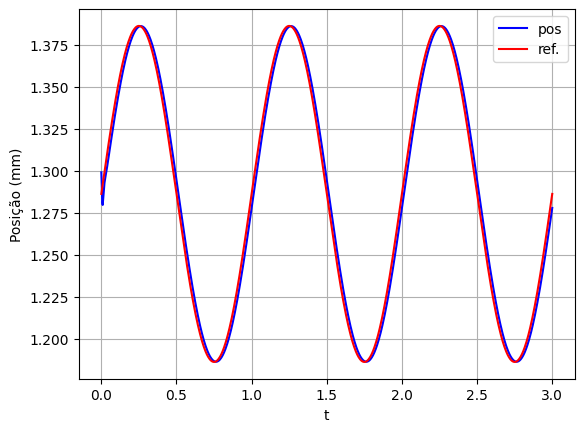

In [12]:
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt


# Sinal de referência (em torno do ponto de equilíbrio)
def ref(t):
  return 1e-4*(np.sin(2*np.pi*t))

# Condições iniciais
ic = [mag.x0*1.01, 0, 0, 0, 0]

# Vetor de tempo (para plotagem)
t = np.linspace(0, 3e0, 1000)

# Solver: simulação de 0 a 5 segundos
sol = solve_ivp(estadosmf,t_span=[0,5],y0=ic, args=(ref, mag,comp), dense_output=True)

# Calcula os estados agora para todos os tempos especificados
y = sol.sol(t)

# Plotagem dos resultados
plt.plot(t, 1e3*y[0,:], 'b', label='pos')
plt.plot(t, 1e3*(mag.x0+ref(t)), 'r', label='ref.')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('Posição (mm)')
plt.grid()
plt.show()